In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile
# import os

# zip_path = '/content/drive/MyDrive/DL_A2/nature_12K.zip'
# extract_path = '/content/drive/MyDrive/DL_A2/dataset'  # or just '/content/' to extract here

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [1]:
import cv2

img = cv2.imread('/kaggle/input/dldata/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg')
height, width, channels = img.shape
print(f'Width: {width}, Height: {height}, Channels: {channels}')

Width: 800, Height: 600, Channels: 3


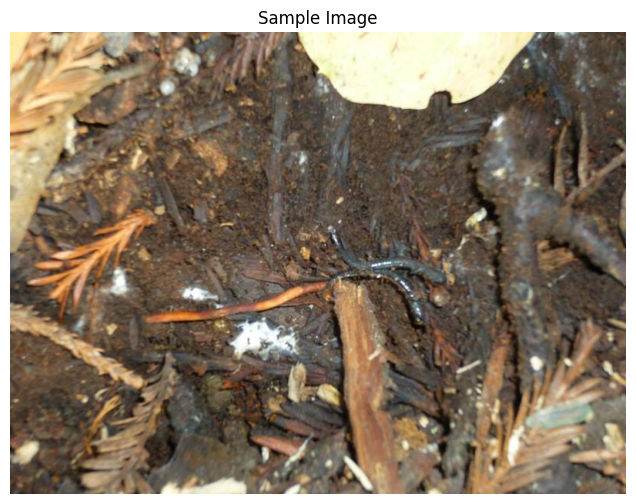

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load image using OpenCV
image_path = '/kaggle/input/dldata/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg'
image = cv2.imread(image_path)

# Convert BGR (OpenCV default) to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Sample Image")
plt.show()

# Part B

In [3]:
%pip install -q wandb

Note: you may need to restart the kernel to use updated packages.


In [3]:
import wandb

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("WANDB_API_KEY") 

wandb.login(key=wandb_api)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m013 (da24m013-iit-madras-alumni-association) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import random
import wandb
import matplotlib.pyplot as plt

In [ ]:
def resnet():
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    random.seed(42)

    # Start wandb
    wandb.init(project="DA6401-A2", name="resnet50_default_transfer")

    # Basic Config
    epochs = 20
    lr = 0.0001
    batch_size = 32
    img_size = 224
    train_path = "/kaggle/input/dldata/inaturalist_12K/train"

    # Data Transforms (No augmentation — just Resize, ToTensor, Normalize)
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # Dataset and Stratified Split
    dataset = datasets.ImageFolder(train_path, transform=transform)
    targets = [s[1] for s in dataset.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(dataset.samples, targets))

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Load Pretrained ResNet50
    model = models.resnet50(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace final fully connected layer
    num_classes = len(dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Move to device
    model = model.to(device)

    # Loss and Optimizer (only for fc layer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    # Accuracy Calculation Function
    def evaluate(model, loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        return 100. * correct / total

    # Training Loop
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            total += y.size(0)
            correct += (preds == y).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate(model, val_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": running_loss / len(train_loader),
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    # Save Model
    torch.save(model.state_dict(), "resnet50_default_finetuned.pth")
    wandb.save("resnet50_default_finetuned.pth")

    # Accuracy Plot
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train vs Val Accuracy (Default ResNet50)")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    wandb.log({"accuracy_plot": wandb.Image("accuracy_plot.png")})

    wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch 1: Train Acc = 48.79%, Val Acc = 68.25%
Epoch 2: Train Acc = 66.76%, Val Acc = 72.30%
Epoch 3: Train Acc = 69.65%, Val Acc = 73.95%
Epoch 4: Train Acc = 71.37%, Val Acc = 74.30%
Epoch 5: Train Acc = 72.45%, Val Acc = 75.55%
Epoch 6: Train Acc = 72.83%, Val Acc = 75.20%
Epoch 7: Train Acc = 73.91%, Val Acc = 76.30%
Epoch 8: Train Acc = 74.00%, Val Acc = 76.05%
Epoch 9: Train Acc = 74.17%, Val Acc = 76.70%
Epoch 10: Train Acc = 74.65%, Val Acc = 76.75%
Epoch 11: Train Acc = 75.50%, Val Acc = 77.30%
Epoch 12: Train Acc = 75.33%, Val Acc = 77.00%
Epoch 13: Train Acc = 74.93%, Val Acc = 77.35%
Epoch 14: Train Acc = 75.17%, Val Acc = 77.25%
Epoch 15: Train Acc = 75.53%, Val Acc = 77.60%
Epoch 16: Train Acc = 76.06%, Val Acc = 77.55%
Epoch 17: Train Acc = 76.15%, Val Acc = 77.85%
Epoch 18: Train Acc = 76.36%, Val Acc = 77.95%
Epoch 19: Train Acc = 76.56%, Val Acc = 77.70%
Epoch 20: Train Acc = 76.07%, Val Acc = 77.30%


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▆▆▇▇▇▇▇▇███████████
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▆▆▇▇▇▇█▇█▇██████
epoch,20
train_acc,76.07201
train_loss,0.72401
val_acc,77.3


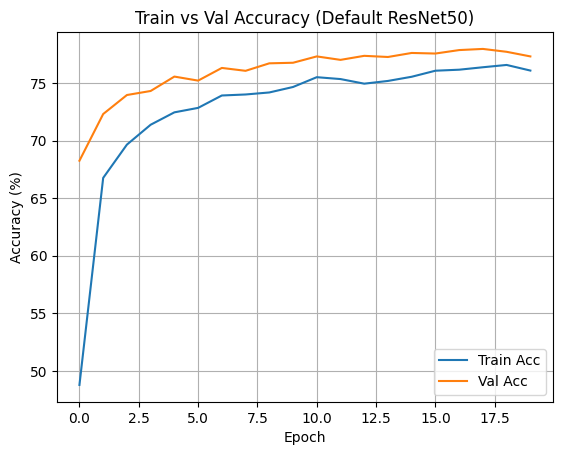

In [ ]:
resnet()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_31/2542692514.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

Test Accuracy: 76.90%


Test Accuracy,▁
Test Accuracy,76.9


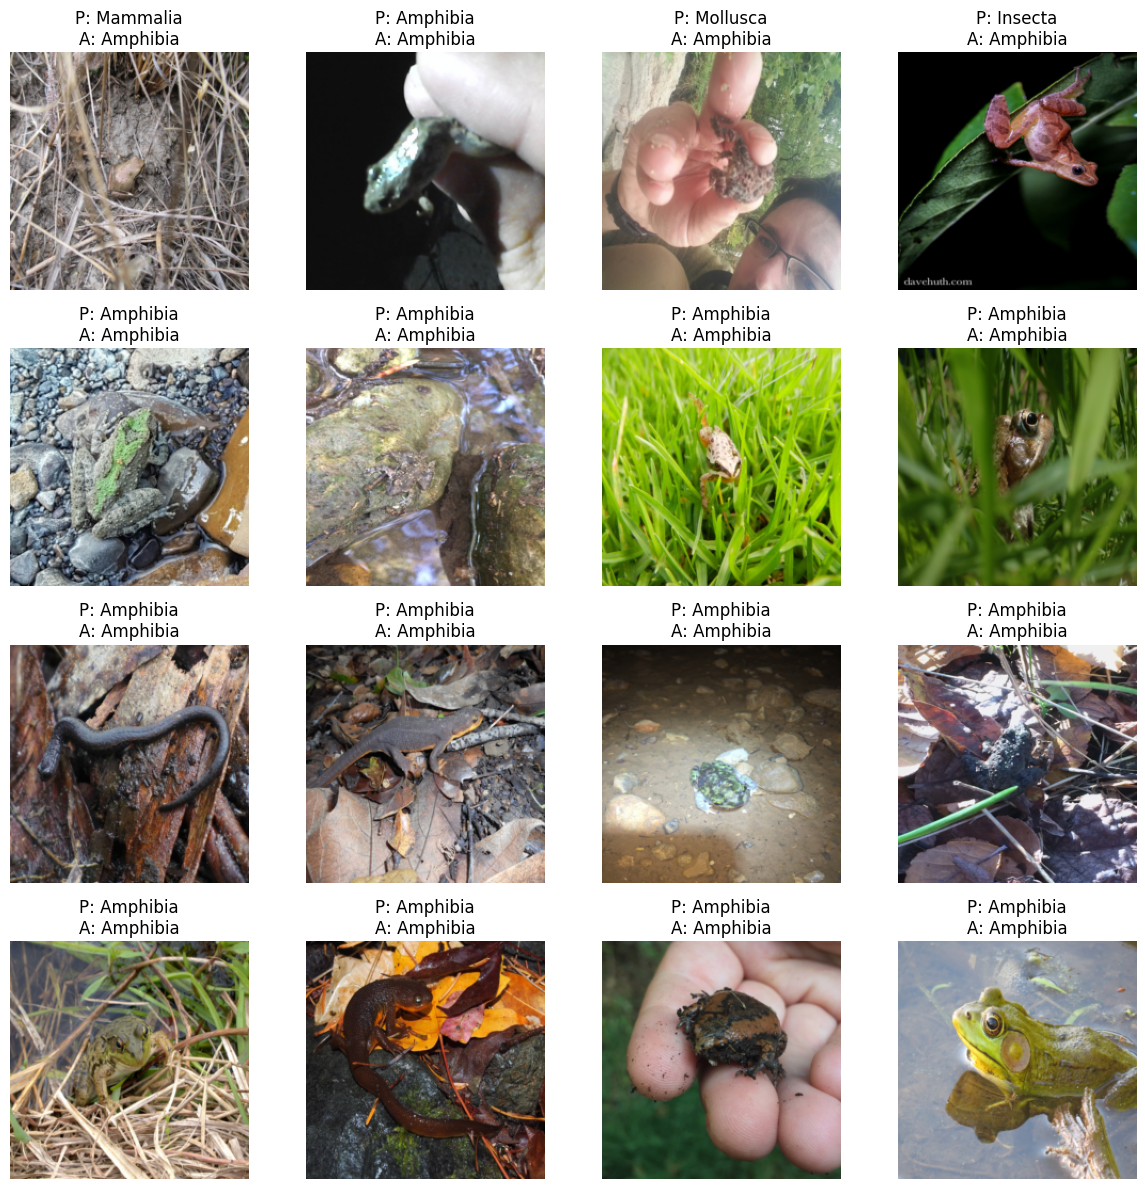

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import wandb
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start wandb
wandb.init(project="DA6401-A2", name="resnet50_default_test")

# Config
img_size = 224
batch_size = 32
val_path = "/kaggle/input/dldata/inaturalist_12K/val"
model_path = "resnet50_default_finetuned.pth"

# Data transforms (same as training)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Dataset
val_dataset = datasets.ImageFolder(val_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
class_names = val_dataset.classes

# Load Pretrained Model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Accuracy Calculation
correct, total = 0, 0
predictions, actuals, images = [], [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        predictions.extend(preds.cpu().numpy())
        actuals.extend(y.cpu().numpy())
        images.extend(x.cpu())

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
wandb.log({"Test Accuracy": test_acc})

# Visualizing Predictions
def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)
    return img

# Show 16 images with predictions
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = imshow(images[i])
    plt.imshow(img)
    plt.title(f"P: {class_names[predictions[i]]}\nA: {class_names[actuals[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig("predictions_grid.png")
wandb.log({"Prediction Grid": wandb.Image("predictions_grid.png")})

wandb.finish()
